# Wine Clustering

As a new business, we only have a certain amount of grapes to produce new wine. Using this data set, we would like to know what types of wines were rated best (and with a good price) in specific areas. From the new information we gather, we want to predict the cost of the new wine that would be on the market based on the price of similar types of wine.


As a consumer new to drinking wine, we want to know what types of wine were rated best for a given province and year. That way, when we are looking at bottles of wines in stores, we would know whether a specific bottle had high ratings. 


In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
%matplotlib inline

In [2]:
# Load the cleaned data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    - Dataset size was reduced from 125,000 rows to 22,000 rows
    
"""

data = pd.read_csv("3column_clean.csv")
data.dropna(subset = ['points', 'price'], inplace = True)
print(data.shape)
data.head()

(116591, 17)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,province_id,variety_numerical,vintage
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1,450,2011
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2,436,2013
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3,479,2013
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2,440,2012
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,4,590,2011


In [3]:
# Extract data for clustering and analysis 

clustering_data = data.loc[:,['province_id','variety_numerical','vintage']]
clustering_data.head()

,province_id,variety_numerical,vintage
1,1,450,2011
2,2,436,2013
3,3,479,2013
4,2,440,2012
5,4,590,2011


In [4]:
# Helper function to count the number of samples in each cluster

def label_count(labels):

	lab_count = dict()

	for x in labels:
		if x in lab_count:
			lab_count[x] += 1
		else:
			lab_count[x] = 1

	print(lab_count)

	return

In [5]:
# Helper function to get the top x in col from data from each cluster

# example usage: get_top_x_per_cluster(x, 'points', data, labels, n)
# x = the top number 'x' from each cluster
# col = the column with an attribute about the dataset
# data = the dataframe with the entire datset
# clusters = the clusters of each point
# n = the number of clusters formed using for k-means

def get_top_x_per_cluster(x, col, data, clusters, n):
    top_lists = [dict() for i in range(n)]
    c = 0
    
    for index, row in data.iterrows():
        i = clusters[c]
        c += 1
        if row[col] in top_lists[i]:
            top_lists[i][row[col]] += 1
        else:
             top_lists[i][row[col]] = 1
    
    print('\nTop', x, col, 'in each cluster')
    for i in range(n):
        print('\nCluster ', i)
        sorted_list = sorted(top_lists[i].items(), key=lambda kv: kv[1])
        sorted_list = list(reversed(sorted_list))
        for y in range(x):
            if(y < len(sorted_list)):
                print(sorted_list[y])
    return
    

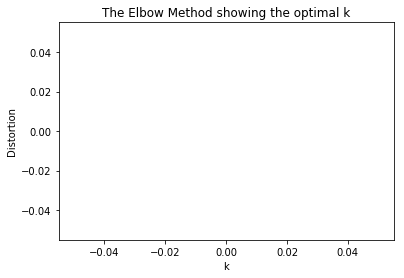

In [6]:
# Determine k using elbow method

X = np.array(list(zip(data.loc[:,'province_id'], data.loc[:,'variety_numerical']))).reshape(len(data.loc[:,'province_id']),2)

# k means determine k
distortions=[]
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
# Normalizing points(rating) between 1 and 0 
data['norm_points'] = abs((data.points - data.points.min()) / (data.points.max()))

In [28]:
# Normalizing price between 1 and 0 
data['norm_price'] = abs((data.price - data.price.min()) / (data.price.max()))

In [30]:
# Gathering normalized data to prepare for clustering
clustering_norm_data = data.loc[:,['norm_price','norm_points']]
clustering_norm_data.head()

,norm_price,norm_points
1,0.003333,0.07
2,0.003030,0.07
3,0.002727,0.07
4,0.018485,0.07
5,0.003333,0.07


In [31]:
# generating the K-Means clusters
n = 8

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_norm_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
#data.loc[:,['province_id','variety_numerical','vintage']]



Clusters:
{0: 31481, 1: 26280, 2: 26264, 3: 12266, 4: 5381, 5: 592, 6: 14316, 7: 11}


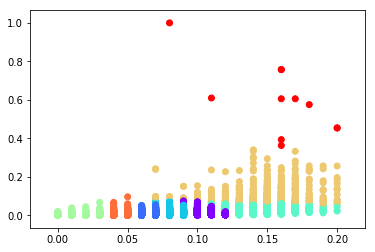

In [32]:
# Scatter plot of the normalized k-means clustering of points and price
plt.scatter(data.loc[:,'norm_points'], data.loc[:,'norm_price'], c=labels, cmap='rainbow')    
plt.show()

In [9]:
# Get top 3 province ids from each cluster formed
get_top_x_per_cluster(3, 'province_id', data, labels, n)

# Get top 3 varieties from each cluster formed
get_top_x_per_cluster(3, 'variety_numerical', data, labels, n)

# Get top 3 vintage from each cluster formed
get_top_x_per_cluster(3, 'vintage', data, labels, n)

('\nTop', 3, 'province_id', 'in each cluster')
('\nCluster ', 0)
(7, 12708)
(16, 3678)
(18, 3143)
('\nCluster ', 1)
(7, 11562)
(2, 3829)
(27, 2067)
('\nCluster ', 2)
(7, 3482)
(4, 641)
(18, 350)
('\nCluster ', 3)
(7, 10)
('\nCluster ', 4)
(31, 2295)
(7, 2155)
(10, 1515)
('\nCluster ', 5)
(7, 4600)
(27, 2517)
(4, 2025)
('\nCluster ', 6)
(116, 215)
(113, 138)
(106, 110)
('\nCluster ', 7)
(43, 991)
(7, 918)
(12, 788)
('\nTop', 3, 'variety_numerical', 'in each cluster')
('\nCluster ', 0)
(125, 10539)
(80, 9321)
(62, 5318)
('\nCluster ', 1)
(440, 12391)
(473, 7830)
(479, 4499)
('\nCluster ', 2)
(702, 2680)
(690, 2019)
(673, 981)
('\nCluster ', 3)
(80, 6)
(62, 3)
(514, 1)
('\nCluster ', 4)
(326, 2986)
(280, 2553)
(383, 2328)
('\nCluster ', 5)
(514, 4478)
(560, 3958)
(506, 2371)
('\nCluster ', 6)
(479, 438)
(473, 402)
(450, 329)
('\nCluster ', 7)
(238, 1139)
(209, 948)
(194, 817)
('\nTop', 3, 'vintage', 'in each cluster')
('\nCluster ', 0)
(2013, 4173)
(2014, 4150)
(2012, 4006)
('\nCluster ',

In [10]:
# Get top 3 points from each cluster formed
get_top_x_per_cluster(3, 'points', data, labels, n)

# Get top 3 price from each cluster formed
get_top_x_per_cluster(3, 'price', data, labels, n)

('\nTop', 3, 'points', 'in each cluster')
('\nCluster ', 0)
(87, 4052)
(88, 3967)
(90, 3745)
('\nCluster ', 1)
(88, 5000)
(87, 4701)
(90, 4582)
('\nCluster ', 2)
(87, 1292)
(88, 1137)
(86, 949)
('\nCluster ', 3)
(89, 4)
(90, 2)
(88, 2)
('\nCluster ', 4)
(88, 1469)
(87, 1394)
(90, 1238)
('\nCluster ', 5)
(88, 2225)
(87, 2174)
(90, 2096)
('\nCluster ', 6)
(88, 400)
(87, 389)
(90, 370)
('\nCluster ', 7)
(88, 1187)
(87, 1069)
(90, 1005)
('\nTop', 3, 'price', 'in each cluster')
('\nCluster ', 0)
(20.0, 1778)
(25.0, 1602)
(15.0, 1515)
('\nCluster ', 1)
(20.0, 2101)
(15.0, 1804)
(25.0, 1743)
('\nCluster ', 2)
(20.0, 514)
(15.0, 507)
(25.0, 419)
('\nCluster ', 3)
(42.0, 2)
(36.0, 2)
(28.0, 1)
('\nCluster ', 4)
(20.0, 516)
(15.0, 502)
(30.0, 474)
('\nCluster ', 5)
(20.0, 910)
(25.0, 811)
(15.0, 782)
('\nCluster ', 6)
(20.0, 213)
(15.0, 188)
(25.0, 148)
('\nCluster ', 7)
(20.0, 622)
(15.0, 500)
(18.0, 467)


## Analysis 

K-means clustering here seems like it has a hard time separating the province between the clusters, possibly because there are so many wines in our dataset with the province with id 7. K-means does do a good job of separating the wine varieties though. The vintage of the wine also does not seem to break into clusters very well because there are only a few different vintages compared to the amount of samples we have. 

Clustering this way does not seem to have an effect on the ratings of the wine though, as each cluster has the same top 3 scores. Same with the price of the wine. This is due to the majority of the wine having a score of ~88 and a price of $20. 

In [11]:
# Agglomerative Clustering was attempted. However, the dataset was too large to successfully run the algorithm 

'''
cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average').fit(clustering_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)
'''

'\ncluster = AgglomerativeClustering(n_clusters=n, affinity=\'euclidean\', linkage=\'average\').fit(clustering_data)\n\nlabels = cluster.labels_\nprint("\n\nClusters:")\nlabel_count(labels)\n'

In [12]:
# Plot for agglomerative clustering

'''
plt.scatter(data.loc[:,'province_id'], data.loc[:,'variety_numerical'], c=labels, cmap='rainbow')    
plt.show()
'''

"\nplt.scatter(data.loc[:,'province_id'], data.loc[:,'variety_numerical'], c=labels, cmap='rainbow')    \nplt.show()\n"

In [13]:
# Retrieve Wine Enthusiast Point Rating and Price column from dataset

data.dropna(subset=['points','price'],inplace=True)
clustering_data = data.loc[:,['points','price']]
clustering_data.head()

,points,price
1,87,15.0
2,87,14.0
3,87,13.0
4,87,65.0
5,87,15.0


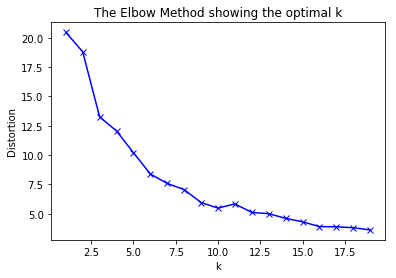

In [14]:
# Determine k using elbow method

X = np.array(list(zip(data.loc[:,'price'], data.loc[:,'points']))).reshape(len(data.loc[:,'price']),2)

# k means determine k
distortions=[]
K = range(1,1)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [15]:
import pylab as pl
Y = data[['price']]
X = data[['points']]

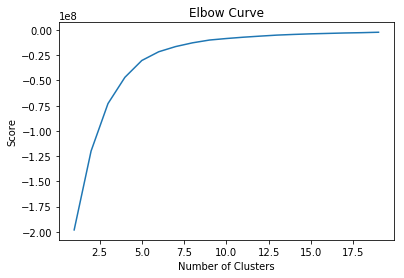

In [16]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

# Score variable denotes the percentage of variance explained by the number of clusters
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [17]:
# Using k-means clustering on dataset based on points and price for each wine.

k = 4

cluster = KMeans(n_clusters = n, random_state = 0).fit(clustering_data)

labels = cluster.labels_
print("\n\nClusters:")
label_count(labels)



Clusters:
{0: 33503, 1: 778, 2: 7, 3: 17198, 4: 203, 5: 60552, 6: 4310, 7: 40}


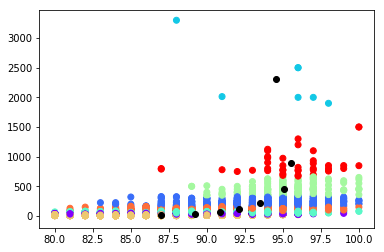

In [18]:
# Plotting results from k-means clustering based on points and price

plt.scatter(data.loc[:,'points'], data.loc[:,'price'], c=labels, cmap='rainbow')    
plt.scatter(cluster.cluster_centers_[:,0] ,cluster.cluster_centers_[:,1], color='black') 
plt.show()

In [19]:
# Get top 3 points from each cluster formed
get_top_x_per_cluster(3, 'points', data, labels, n)

# Get top 3 price from each cluster formed
get_top_x_per_cluster(3, 'price', data, labels, n)

('\nTop', 3, 'points', 'in each cluster')
('\nCluster ', 0)
(90, 5492)
(91, 4590)
(88, 4448)
('\nCluster ', 1)
(94, 179)
(95, 138)
(93, 115)
('\nCluster ', 2)
(96, 3)
(88, 1)
(91, 1)
('\nCluster ', 3)
(92, 3003)
(91, 2522)
(93, 2401)
('\nCluster ', 4)
(95, 56)
(96, 37)
(94, 27)
('\nCluster ', 5)
(87, 10554)
(88, 9360)
(86, 8592)
('\nCluster ', 6)
(93, 816)
(94, 719)
(92, 658)
('\nCluster ', 7)
(94, 7)
(96, 7)
(95, 6)
('\nTop', 3, 'price', 'in each cluster')
('\nCluster ', 0)
(30.0, 4793)
(40.0, 3762)
(35.0, 3706)
('\nCluster ', 1)
(200.0, 93)
(175.0, 80)
(250.0, 51)
('\nCluster ', 2)
(2500.0, 2)
(2000.0, 2)
(2013.0, 1)
('\nCluster ', 3)
(50.0, 3218)
(60.0, 2193)
(55.0, 1921)
('\nCluster ', 4)
(450.0, 24)
(350.0, 19)
(400.0, 16)
('\nCluster ', 5)
(20.0, 6654)
(15.0, 5798)
(25.0, 5622)
('\nCluster ', 6)
(90.0, 650)
(100.0, 565)
(95.0, 384)
('\nCluster ', 7)
(800.0, 5)
(775.0, 4)
(850.0, 3)


# Conclusion

We ran our dataset using the k-means algorithm and attempted to cluster using agglomerative clustering. We were able to run KMeans clustering on our data without any issues. However, due to the size of our dataset ~125K entries, we were unable to successfuly run Agglomerative on our data. 

We used these clustering methods to explore and visulize our data, and were looking for valuble insights. 

We have clusters that are both densly populated and a wide distribution of points scattered across the visualization plot. 